In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')

inout = []
for i in morph_db.index:
    for ii in range(len(morph_db.zgrism_hci[i])//2):
        if morph_db.zgrism_hci[i][2*ii] <= morph_db.zgrism[i] <= morph_db.zgrism_hci[i][2*ii+1]:
            if(morph_db.zgrism_hci[i][2*ii+1] - morph_db.zgrism_hci[i][2*ii]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        
morph_db['inout'] = inout
morph_db = morph_db.query('inout == "i" and n_f < 3 and Re < 20')

mdb = morph_db.query('n_f < 3 and lmass >= 10.5')
mdbs = morph_db.query('n_f < 3 and lmass >= 11 and Re < 2')

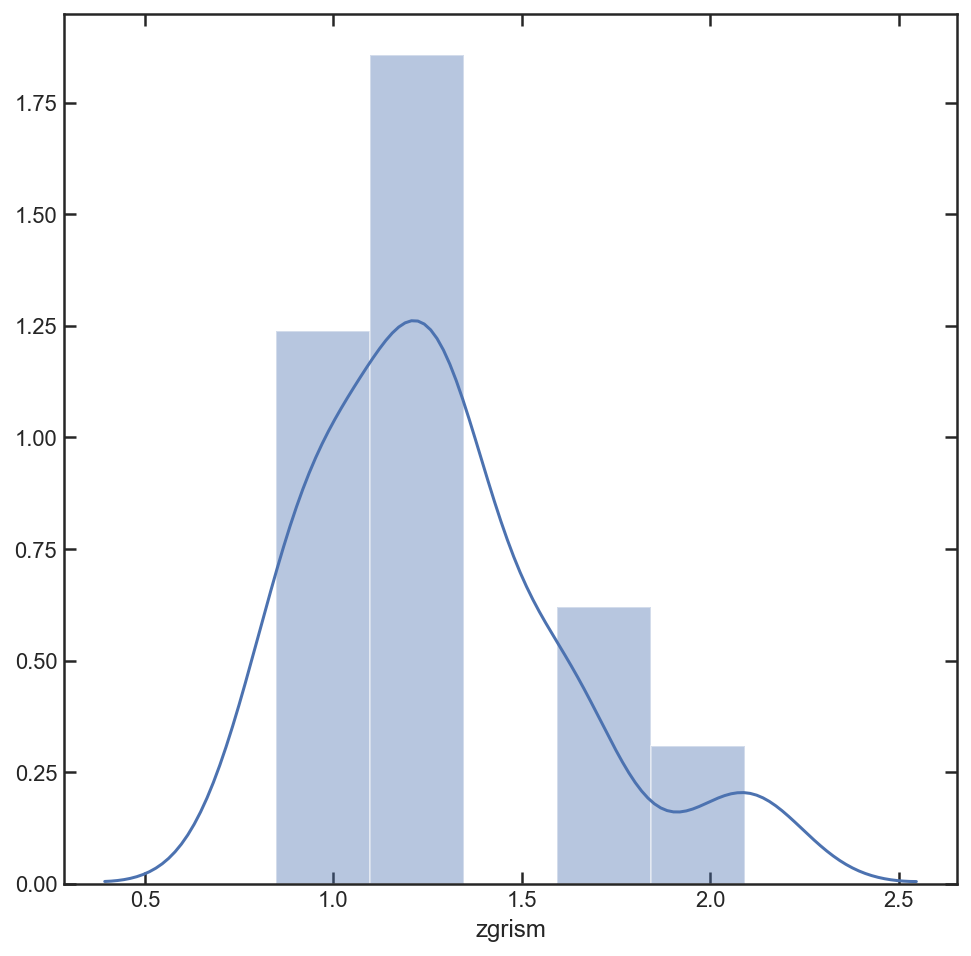

In [65]:
plt.figure(figsize=[8,8])
sea.distplot(mdbs.zgrism)

In [18]:
sb_z, sb_sfh = np.loadtxt('../data/evo_path/SB_SFH.dat').T
ef_z, ef_sfh = np.loadtxt('../data/evo_path/EF_SFH.dat').T

In [21]:
def get_agebins(maxage, binnum = 10):
    lages = [0,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9][: binnum + 1]
    
    nbins = len(lages) - 1

    tbinmax = (maxage * 0.85) * 1e9
    lim1, lim2 = 7.4772, 8.0
    agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(maxage*1e9)]
    return np.array([agelims[:-1], agelims[1:]]).T

In [76]:
# 2.566
agebins = get_agebins(2.566+1.85)

In [77]:
sb_lwa = cosmo.lookback_time(sb_z).value - min(cosmo.lookback_time(sb_z)).value
ef_lwa = cosmo.lookback_time(ef_z).value - min(cosmo.lookback_time(ef_z)).value
blims = 10**agebins.T[1] * 1E-9
blims = np.append(0.0, blims)

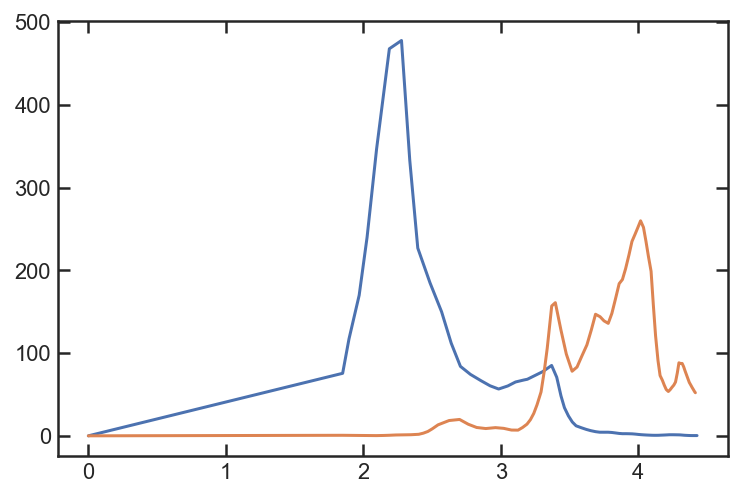

In [68]:
plt.plot((np.append(-1.85,sb_lwa) + 1.85), np.append(0,sb_sfh))
plt.plot((np.append(-1.85,ef_lwa) + 1.85), np.append(0,ef_sfh))

In [71]:
isb_lwa = np.linspace((np.append(-1.85,sb_lwa) + 1.85)[0],(np.append(-1.85,sb_lwa) + 1.85)[-1],1000)
isb_sfh = interp1d((np.append(-1.85,sb_lwa) + 1.85),np.append(0,sb_sfh))(isb_lwa)

ief_lwa = np.linspace((np.append(-1.85,ef_lwa) + 1.85)[0],(np.append(-1.85,ef_lwa) + 1.85)[-1],1000)
ief_sfh = interp1d((np.append(-1.85,ef_lwa) + 1.85),np.append(0,ef_sfh))(ief_lwa)

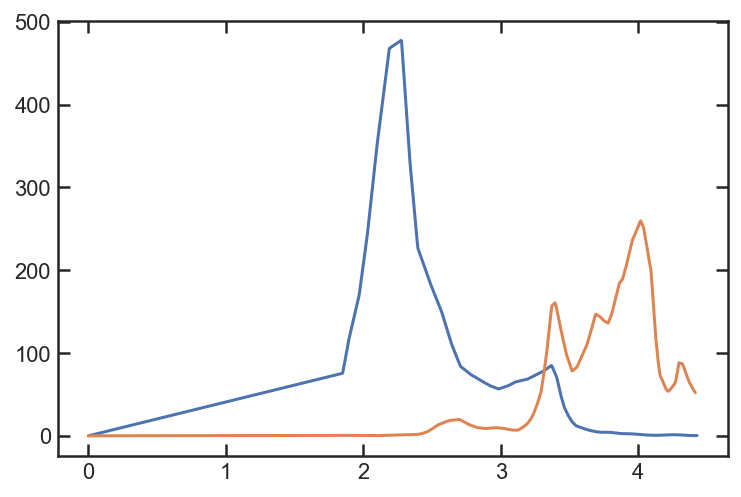

In [72]:
plt.plot(isb_lwa, isb_sfh)
plt.plot(ief_lwa, ief_sfh)

0.00014066774715095487
0.0015860087073127356
0.003180855051811586
0.00898742220394841
0.025391235481306434
0.07170048385807383
0.2024054821431116
0.4862176457444667
65.22323378068721
94.68016882817801


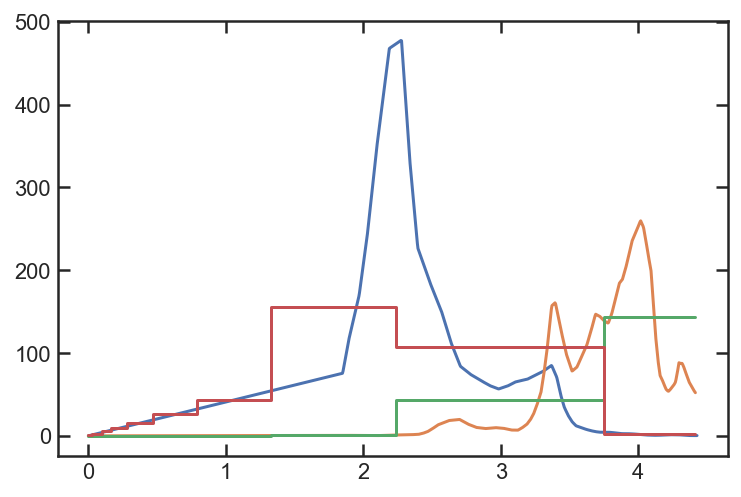

In [78]:
plt.plot(isb_lwa, isb_sfh)
plt.plot(ief_lwa, ief_sfh)

ef_T = [0]
ef_SFH= []
for i in range(len(blims) - 1):
    sfh_bin = []
    for ii in range(len(ief_lwa)):
        if blims[i] <= ief_lwa[ii] < blims[i+1]:
            sfh_bin.append(ief_sfh[ii])
    ef_SFH.append(np.mean(sfh_bin))
    ef_SFH.append(np.mean(sfh_bin))
    if i < len(blims) - 2 : 
        ef_T.append(blims[i+1])
        ef_T.append(blims[i+1])
    else:
        ef_T.append(blims[i+1])
    print(np.mean(sfh_bin) * (blims[i+1] - blims[i]))

plt.plot(ef_T,ef_SFH)

sb_T = [0]
sb_SFH= []
for i in range(len(blims) - 1):
    sfh_bin = []
    for ii in range(len(isb_lwa)):
        if blims[i] <= isb_lwa[ii] < blims[i+1]:
            sfh_bin.append(isb_sfh[ii])
    sb_SFH.append(np.mean(sfh_bin))
    sb_SFH.append(np.mean(sfh_bin))
    if i < len(blims) - 2 : 
        sb_T.append(blims[i+1])
        sb_T.append(blims[i+1])
    else:
        sb_T.append(blims[i+1])

#     print(np.mean(sfh_bin) * (blims[i+1] - blims[i]))
        
plt.plot(sb_T,sb_SFH)

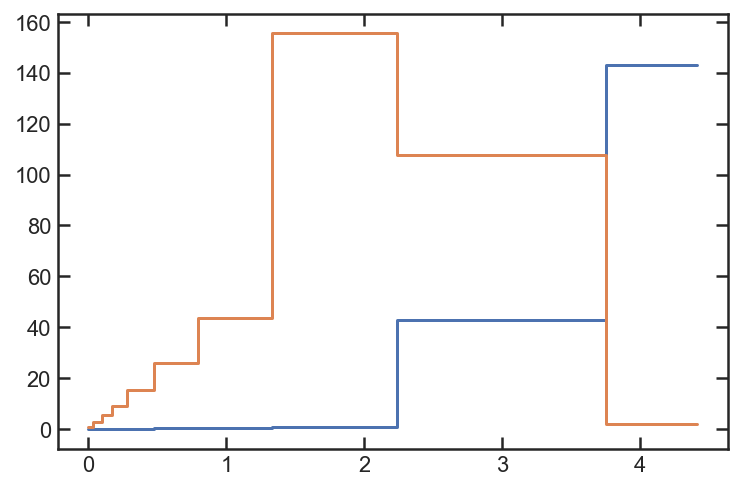

In [79]:
plt.plot(ef_T,ef_SFH)
plt.plot(sb_T,sb_SFH)

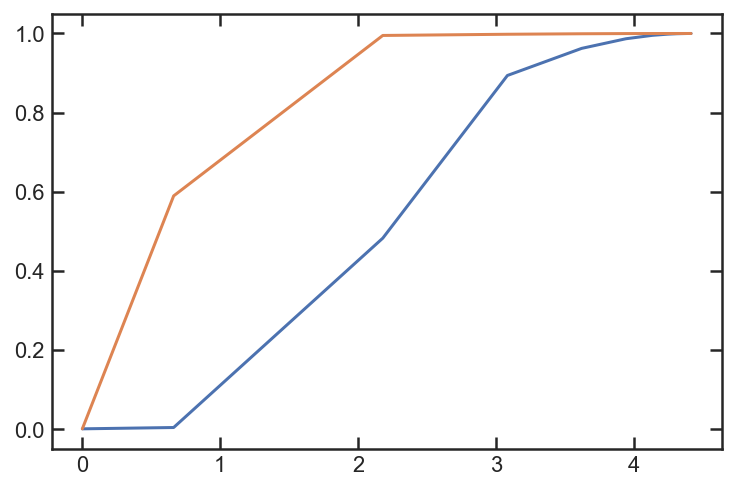

In [110]:
T=[0]
M=[0]

lbt = np.abs(sb_T - sb_T[-1])[::-1]
lbsfr = sb_SFH[::-1]

for i in range(len(lbt)//2):
    mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
    M.append(M[i] + mass)
    T.append(lbt[i*2+1])
    
plt.plot(T,M/M[-1])

T=[0]
M=[0]

lbt = np.abs(ef_T - ef_T[-1])[::-1]
lbsfr = ef_SFH[::-1]

for i in range(len(lbt)//2):
    mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
    M.append(M[i] + mass)
    T.append(lbt[i*2+1])
    
plt.plot(T,M/M[-1])

0.1531588806680444 13774 2.652500656016183
0.3542262367928742 17070 4.176152106766585
0.0446623091545133 22213 5.657209759485417
0.16027460826632445 27185 2.9868710817276236
0.09111547366989958 37340 3.751786693206122
0.0008390481516691306 37686 3.2510609102134893
-0.01939289757104301 39804 3.002544670007443
0.09072954666040922 40597 2.3589630486019972
0.029819226740751548 41520 4.382773386805168
0.02434560701135191 17746 5.640696320380857
0.030273765008758557 21738 5.743797573958715
0.34195059016321405 39012 7.063552848581166
-0.14373592785585165 46066 6.209742281626355


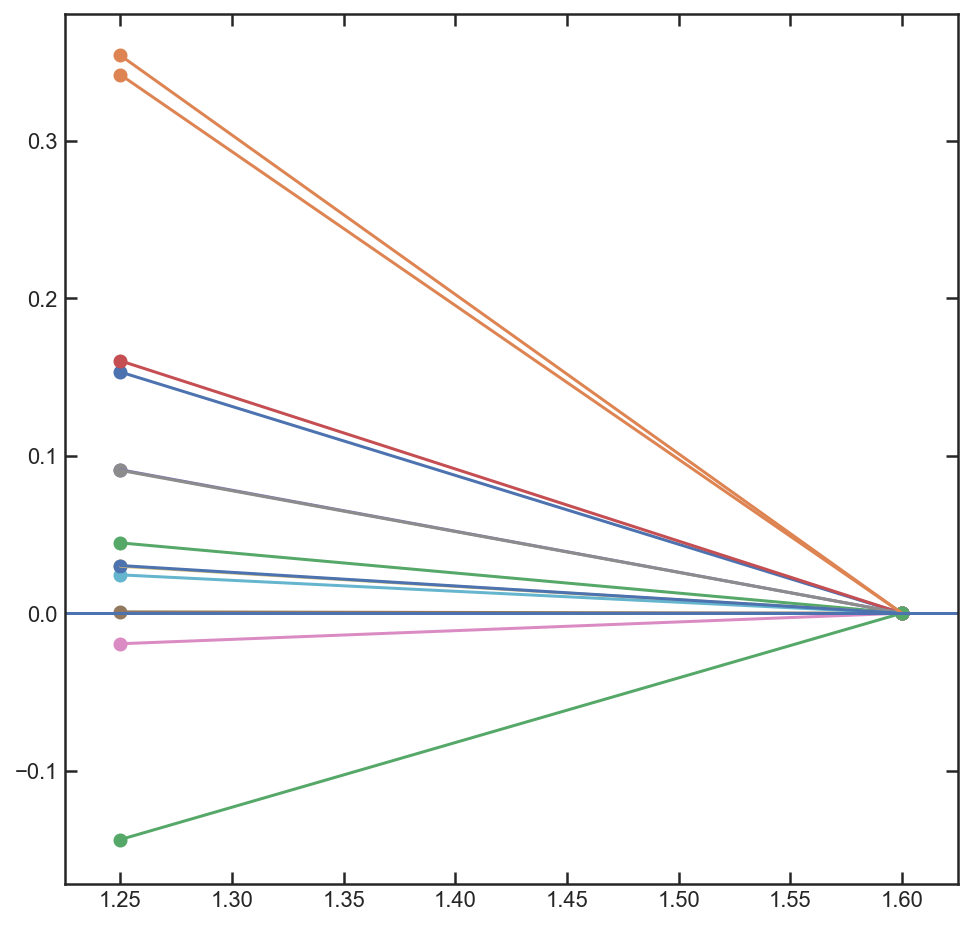

In [94]:
idx = 0
plt.figure(figsize=[8,8])
for i in mdbs.index:
    plt.scatter([1.25,1.6],[mdbs.Re_f125[i]-mdbs.Re_f160[i],mdbs.Re_f160[i]-mdbs.Re_f160[i]])
    plt.plot([1.25,1.6],[mdbs.Re_f125[i]-mdbs.Re_f160[i],mdbs.Re_f160[i]-mdbs.Re_f160[i]])
#     if mdbs.Re_f125[i]-mdbs.Re_f160[i] < 0:
    print(mdbs.Re_f125[i]-mdbs.Re_f160[i], mdbs.id[i], mdbs.z_50[i])
plt.axhline(0)

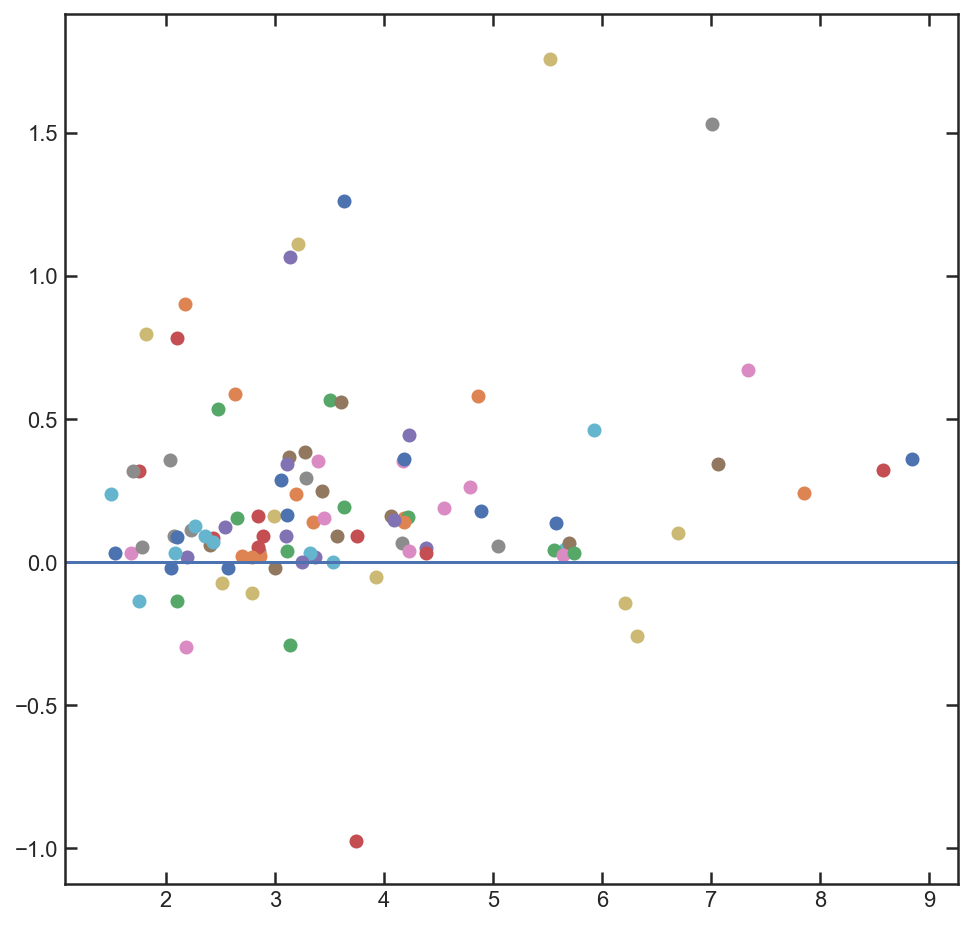

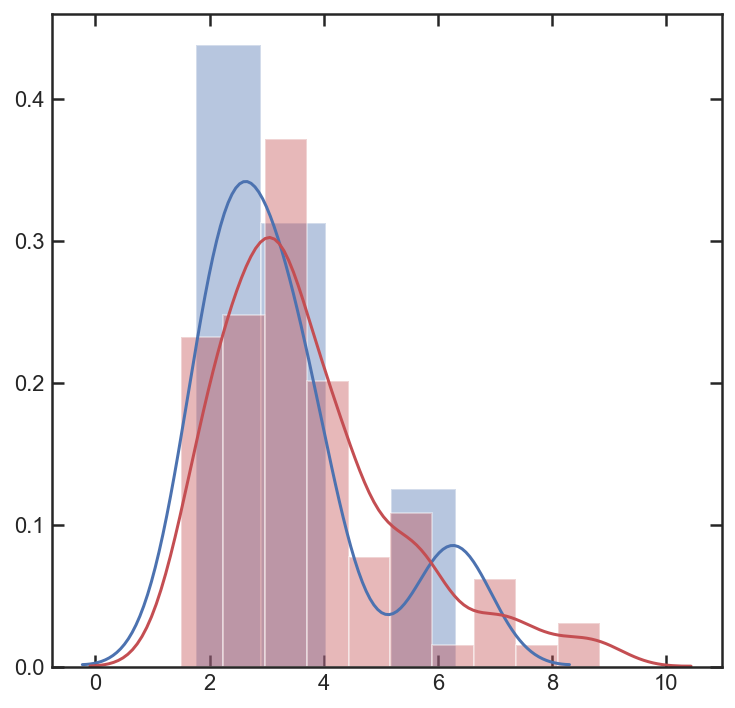

In [102]:
idx = 0
plt.figure(figsize=[8,8])

EF = []
SB = []
for i in mdb.index:
    plt.scatter(mdb.z_50[i],mdb.Re_f125[i]-mdb.Re_f160[i])
    
    if mdb.Re_f125[i]-mdb.Re_f160[i] < 0:
        SB.append(mdb.z_50[i])
    else:
        EF.append(mdb.z_50[i])
        
plt.axhline(0)

plt.figure(figsize=[6,6])
sea.distplot(SB, color = 'b')
sea.distplot(EF, color = 'r')


(10.03, 8.85)

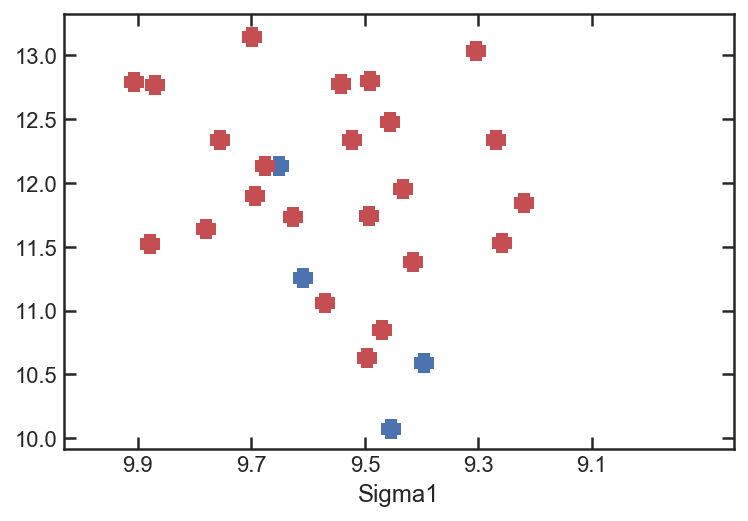

In [113]:
sb_mdb = mdb.query('Re_f125 - Re_f160 <= 0 and 0.9 < zgrism < 1.1 and n_f < 2')
ef_mdb = mdb.query('Re_f125 - Re_f160 > 0 and 0.9 < zgrism < 1.1 and n_f < 2')

sea.scatterplot(np.log10(sb_mdb.Sigma1), cosmo.lookback_time(sb_mdb.z_50),
        marker="+", color = 'b', alpha = 1, linewidth = 10)
sea.scatterplot(np.log10(ef_mdb.Sigma1), cosmo.lookback_time(ef_mdb.z_50),
        marker="+", color = 'r', alpha = 1, linewidth = 10)

plt.xticks([ 9.9, 9.7, 9.5, 9.3, 9.1])
plt.xlim(10.03,8.85)

In [115]:
sb_mdb[['field','id']]

,field,id
0,GND,12078
24,GND,27714
51,GSD,39241
68,GSD,45789
